# Data munging for Pubmed and CORD-19

- Our objective here is to join these 2 datasets together so that we can use them to do textual analysis.

## Data
#### Merging the data
- need to get pmids/dois for COVID-19 articles and filter those out
  
#### Training dataset
- add, say, 60% of the text-data for COVID-19. 
    
#### Dev and test sets
- for dev and test, take 20% of covid-19 and add a random sample of pubmed approximately the same size.
- you might find that the sample of pubmed is not representative of real-world data, so you may have to have a larger sample with imbalanced classes.

#### Modelling issues to consider
- start with Doc2Vec and SVMs and see what you get. Then try a few other models and iterate. 
  - this worked ok, but had a lot of errors. 
  - switched to spaCy categorizer, which seems better.
- it might also be nice to try a full-text model - maybe LDA / TFIDF and use it as a baseline?
- transfer learning could save a lot of time. Consider SciSpaCy and SciBERT.
- With this much data, you could get good results with deep-learning models.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# read in the data
pubmed = pd.read_csv('data/pubmed_sample.csv', dtype=str, index_col = 0)
covid = pd.read_csv('data/s2_cr_data.csv', dtype=str)
covid.shape, pubmed.shape

((34185, 22), (1020660, 9))

In [3]:
# rename some columns so that they match for merging
pubmed = pubmed.rename(columns = {'title':'venue','articletitle':'title'})

## Drop duplicates

In [4]:
pubmed = pubmed.drop_duplicates(subset = ['pmid','doi','title'], keep = 'first')
covid = covid.drop_duplicates(subset = ['doi','title'], keep = 'first')
pubmed.shape, covid.shape

((1020653, 9), (34185, 22))

## Drop matching DOIs
Avoid having the same article in both datasets where possible.

In [5]:
# make a set of dois in the covid dataset
covid_doi_set = set([str(x) for x in covid.doi.unique() if str(x) not in {'nan','None',''}])
# if any of those DOIs are in the pubmed data, drop those rows
pubmed = pubmed[~pubmed.doi.isin(covid_doi_set)]
pubmed.shape

(1018760, 9)

## Drop matching titles
Avoid having the same article in both datasets where possible.

In [6]:
# try dropping matching titles.
covid_title_set = set([str(x) for x in covid.title.unique() if str(x) not in {'nan','None'}])
pubmed[~pubmed.title.isin(covid_title_set)].shape, len(list(covid_title_set))

((1018760, 9), 34185)

In [7]:
pubmed = pubmed[~pubmed.title.isin(covid_title_set)]
pubmed.shape, covid.shape

((1018760, 9), (34185, 22))

# Text pre-processing

Pubmed has some odd peculiarities.
- Adds '.' to the end of titles
- Copyright statement in abstract
- Some characters in pubmed not in cord-19

Both datasets have occasionally 'Background' 'methods' 'abstract' etc showing up within the abstract.

Want to avoid including non-semantic text features that might allow a classifier to discriminate between the 2 datasets.

In [8]:
# recall that pubmed adds '.' to titles. Delete this. 
pubmed['title'] = [str(x)[:-1] if str(x)[-1]=='.' else str(x) for x in pubmed['title']]
covid['title'] = [str(x)[:-1] if str(x)[-1]=='.' else str(x) for x in covid['title']]

Before appending abstracts, get rid of annoying copyright statements

In [9]:
# from tools import pre_s

In [95]:
from tools import pre_s

In [96]:
%%time
covid['abstract_pre'] = covid['abstract'].map(lambda x:pre_s(str(x).lower()))

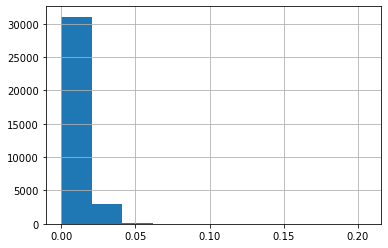

In [97]:
# # # length comparison. did we delete too much text?
delta_lens = []
for i,row in covid.iterrows():
    abstract = row['abstract']
    abstract_pre = row['abstract_pre']
    len_abs = len(str(abstract).split())
    len_abs_pre = len(str(abstract_pre).split())
    # what proportion of abstract are we deleting?
    delta_lens.append((len_abs-len_abs_pre)/(len_abs+1))
pd.Series(delta_lens).hist()

In [ ]:
%%time
pubmed['abstract_pre'] = pubmed['abstract'].map(lambda x:pre_s(str(x).lower()))

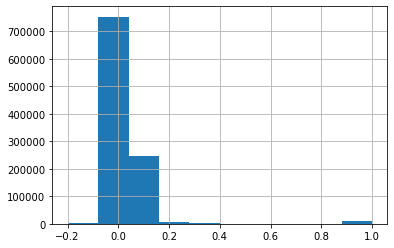

In [98]:
delta_lens = []
for i,row in pubmed.iterrows():
    abstract = row['abstract']
    abstract_pre = row['abstract_pre']
    len_abs = len(str(abstract).split())
    len_abs_pre = len(str(abstract_pre).split())
    # what proportion of abstract are we deleting?
    delta_lens.append((len_abs-len_abs_pre)/(len_abs+1))
pd.Series(delta_lens).hist()

In [108]:
# check odd ones...

pubmed['delta'] = delta_lens

In [109]:
# pubmed[[(x<0.0 or x>0.4) for x in pubmed['delta'].tolist()]].shape

(13064, 13)

In [110]:
pubmed = pubmed[[(x>0.0 or x<0.4) for x in pubmed['delta'].tolist()]]

In [111]:
# %%time
# # check that preprocessing hasn't broken anything
# length = 2000
# pd.DataFrame({
#               'Orig_abs':covid['abstract'].head(length),
#               'Pre_abs': covid['abstract'].head(length).map(lambda x: pre_s(x))
#              }).to_csv('deleteme.csv', index=False)

In [112]:
pubmed['tiabs'] = pubmed['title'] +'. '+pubmed['abstract_pre']

In [113]:
covid['tiabs'] = covid['title'] +'. '+covid['abstract_pre']

## Detect language and remove non-english entries

In [105]:
import langdetect

In [106]:
%%time
covid['lang'] = covid['tiabs'].map(lambda x: langdetect.detect(x))
covid.shape, covid[covid['lang']=='en'].shape

Wall time: 3min 14s


((34185, 24), (33845, 24))

In [107]:
%%time
pubmed['lang'] = pubmed['tiabs'].map(lambda x: langdetect.detect(x))
pubmed.shape, pubmed[pubmed['lang']=='en'].shape

Wall time: 1h 34min 49s


((1018760, 12), (1005668, 12))

In [114]:
pubmed = pubmed[pubmed['lang']=='en']
covid = covid[covid['lang']=='en']

In [8]:
pubmed.shape, covid.shape

((1020653, 10), (34185, 22))

# drop nas

In [115]:
pubmed = pubmed[~pubmed['tiabs'].isna()]
covid = covid[~covid['tiabs'].isna()]
pubmed.shape, covid.shape

((1005668, 13), (33845, 24))

I'm concerned that we haven't filtered out enough covid-related content from the pubmed part of this to get a good classifier.

Inevitably, we are going to have some issues because the 2 datasets do not definitely define what IS and IS not covid-related. But without that, we can still make something that works generally.

- Consider using keywords to drop more content from pubmed.

#### Get rid of any odd characters
Sometimes, we see odd characters and odd pieces of language which are not in one set or the other. 
- In some cases, we should probably replace these. E.g. consistent use of dashes, M-rules, N-rules and consistent use of different types of inverted commas "\'\` etc.
- Here we are simply deleting odd characters.

In [116]:
# any unusual features in one set and not the other

pubmed_chars = []
for tiabs in pubmed['tiabs'].values:
    pubmed_chars.extend([x for x in str(tiabs)])
    pubmed_chars = list(set(pubmed_chars))
pubmed_set = set(pubmed_chars)

covid_chars = []
for tiabs in covid['tiabs'].values:
    covid_chars.extend([x for x in str(tiabs)])
    covid_chars = list(set(covid_chars))
covid_set =  set(covid_chars)
drop_chars = covid_chars+pubmed_chars
# [x for x in covid_chars if x not in pubmed_set], [x for x in pubmed_chars if x not in covid_set]
                 

In [117]:
# drop_chars

In [118]:
def drop_unusual_chars(x, drop_chars):
    for drop_char in drop_chars:
        x.replace(drop_char,'')
    return x
pubmed['tiabs'] = pubmed['tiabs'].map(lambda x: drop_unusual_chars(x, drop_chars))
covid['tiabs'] = covid['tiabs'].map(lambda x: drop_unusual_chars(x, drop_chars))

# replace any linebreaks with spaces

In [119]:
pubmed['tiabs'] = [x.replace('\n',' ') for x in pubmed['tiabs'].values]
covid['tiabs'] = [x.replace('\n',' ') for x in covid['tiabs'].values]

# Drop length-outliers
Get rid of super-short or super-long pieces of text. This will include:
- odd articles like missing abstracts or very long articles (e.g. editorial or book chapter that ended up in my abstract field)

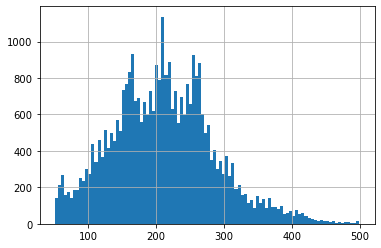

In [140]:
pd.Series([len(str(x).split()) for x in covid['tiabs'].values]).hist(bins=100)

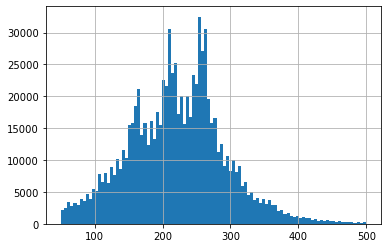

In [141]:
pd.Series([len(str(x).split()) for x in pubmed['tiabs'].values]).hist(bins=100)

In [120]:
pubmed = pubmed[[(len(str(x).split())>50) and (len(str(x).split())<500) for x in pubmed['tiabs'].values]]
covid = covid[[(len(str(x).split())>50) and (len(str(x).split())<500) for x in covid['tiabs'].values]]

Some pubmed articles have capitalised titles. Try lower-casing everything.

In [121]:
covid['tiabs'] = covid['tiabs'].map(lambda x: x.lower())
pubmed['tiabs'] = pubmed['tiabs'].map(lambda x: x.lower())

# Get rid of any null values
Our cleaning process might have created a few null entries. Drop those lines. 

In [124]:
covid =  covid.dropna(subset=['tiabs'],axis =0)
pubmed = pubmed.dropna(subset=['tiabs'],axis =0)
covid.shape, pubmed.shape

((33654, 24), (862887, 13))

## Build datasets

In [125]:
# add a response columne
covid['covid'] = 1
pubmed['covid'] = 0

In [126]:
# # write out all data
pd.concat([pubmed,covid]).to_csv('data/all.csv', encoding = 'utf-8-sig')

## For model training
If you are training a model, you want to get a large sample of pubmed which you can use to teach it what that corpus looks like.

If you are NOT training a model (just a classifier), then you just need a large sample of cord-19 and a representative sample of pubmed. Ideally these should be the same size.

In [127]:
covid = covid.reset_index()

In [128]:
# set a random_state variable so that we get the same datasets if we re-run this notebook later with the same input.
rs = 100
# create train/test/dev sets for cord-19 dataset

covid_train = covid.sample(int(0.6*covid.shape[0]), random_state = rs)
covid_devtest = covid[~covid['index'].isin(set(covid_train['index']))]
covid_dev = covid_devtest.sample(int(covid_devtest.shape[0]/2), random_state = rs)
covid_test = covid_devtest[~covid_devtest['index'].isin(set(covid_dev['index']))]
covid_train.shape, covid_dev.shape, covid_test.shape

((20192, 26), (6731, 26), (6731, 26))

In [129]:
# create train/test/dev sets for pubmed data
pubmed_test = pubmed.sample(covid_dev.shape[0], random_state = rs)
pubmed_traindev = pubmed[~pubmed['pmid'].isin(set(pubmed_test['pmid']))]
pubmed_dev = pubmed_traindev.sample(covid_dev.shape[0], random_state = rs)
pubmed_train = pubmed_traindev[~pubmed_traindev['pmid'].isin(set(pubmed_dev['pmid']))]

pubmed_train.shape, pubmed_dev.shape, pubmed_test.shape

((849401, 14), (6731, 14), (6731, 14))

In [130]:
# combine the train,test,dev subsets for pubmed and cord19 into dataframes
train = pd.concat([pubmed_train, covid_train])
test = pd.concat([pubmed_test, covid_test])
dev = pd.concat([pubmed_dev, covid_dev])

# randomize
train = train.sample(train.shape[0], random_state=rs)
test = test.sample(test.shape[0], random_state=rs)
dev = dev.sample(dev.shape[0], random_state=rs)

train.shape, test.shape, dev.shape

((869593, 32), (13462, 32), (13462, 32))

In [139]:
train.columns

Index(['venue', 'title', 'abstract', 'year', 'articledate', 'doi', 'pmid',
       'pii', 'pmc', 'abstract_pre', 'tiabs', 'lang', 'delta', 'covid',
       'index', 'pid', 'source_x', 'pmcid', 'pubmed_id', 'license',
       'publish_time', 'authors', 'journal', 'Microsoft Academic Paper ID',
       'WHO #Covidence', 'has_full_text', 'full_text_file', 'journal-short',
       'pubdate', 'issns', 'publisher', 'cr_dates'],
      dtype='object')

## Write out

In [131]:
train.to_csv('data/train.csv', encoding = 'utf-8-sig',index=False)
test.to_csv('data/test.csv', encoding = 'utf-8-sig',index=False)
dev.to_csv('data/dev.csv', encoding = 'utf-8-sig',index=False)

# If we are using SciSpacy, we don't necessarily need such a large training set. 
We already have a model which should have the features we need in it. So hopefully we don't need a lot of examples to train the classifier.

Try using these datasets and see how that goes. 

In [132]:
# set a random_state variable so that we get the same datasets if we re-run this notebook later with the same input.
rs = 100
# create train/test/dev sets for cord-19 dataset
covid_train = covid.sample(int(0.8*covid.shape[0]), random_state = rs)
covid_test = covid[~covid['index'].isin(set(covid_train['index']))]
covid_train.shape, covid_test.shape

((26923, 26), (6731, 26))

In [133]:
# create train/test/dev sets for pubmed data
pubmed_test = pubmed.sample(covid_test.shape[0], random_state = rs)
pubmed = pubmed[~pubmed['pmid'].isin(set(pubmed_test['pmid']))]
pubmed_train = pubmed[~pubmed['pmid'].isin(set(pubmed_test['pmid']))].sample(int(0.8*covid.shape[0]), random_state = rs)

pubmed_train.shape, pubmed_test.shape

((26923, 14), (6731, 14))

In [134]:
# combine the train,test,dev subsets for pubmed and cord19 into dataframes
train = pd.concat([pubmed_train, covid_train])
test = pd.concat([pubmed_test, covid_test])

# randomize again...
train = train.sample(train.shape[0], random_state=rs)
test = test.sample(test.shape[0], random_state=rs)

train.shape, test.shape

((53846, 32), (13462, 32))

# any duplicates? leakage?

In [135]:
train_titles = set(train['tiabs'].values)
test_titles = set(test['tiabs'].values)
train_in_test = len([x for x in test['tiabs'] if x in train_titles])
test_in_train = len([x for x in train['tiabs'] if x in test_titles])
len(train_titles), len(train['tiabs'].values),len(test_titles), len(test['tiabs'].values), train_in_test, test_in_train

(53841, 53846, 13461, 13462, 0, 0)

In [136]:
assert [x for x in train['title'] if x in test_titles] == []

Don't see any signs of data leakage. Some titles are null, but we knew that. 

## Write out

In [137]:
train.shape, test.shape

((53846, 32), (13462, 32))

In [138]:
train.to_csv('data/train_scispacy.csv', encoding = 'utf-8-sig',index=False)
test.to_csv('data/test_scispacy.csv', encoding = 'utf-8-sig',index=False)
